# Modelowanie układów przepływowaych - shallow water equation
## Pytanie badawcze

**Jak zachowuje się niska oraz długa fala, w momencie napotkania zmiany wysokości (zbliżanie się do plaży)?**  
W szczególności:

- jak zmienia się **kształt** fali oraz co dzieje się z jej **długość**, **amplitudą** i **prędkością**?

- Na jakiej głębokości zaczyna się shoaling (moment, gdy amplituda zaczyna rosnąć), a kiedy się kończy w zależności od głębokości na jakiej powstała fala? Jaka się amplituda fali w momencie zakończenia shoalingu?



In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
from pint import UnitRegistry
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions


In [3]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, options: Options = None, bathymetry: np.ndarray, uh_initial: np.ndarray = None, vh_initial: np.ndarray = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid, n_threads = 1)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }
        if uh_initial is None:
            uh_initial = np.zeros(grid, dtype=float)
        if vh_initial is None:
            vh_initial = np.zeros(grid, dtype=float)
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(uh_initial, **kwargs),
            "vh": ScalarField(vh_initial, **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }
        self.bathymetry = bathymetry

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h']-self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[(
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        if np.amax(np.abs(courant_number)) > 1:
            print("Courant too big:", np.amax(np.abs(courant_number)))
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1):
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

In [4]:
g = 10.0

# fizyczne jednostki
si = UnitRegistry()
Lx = 100 * si.m
Ly = 25 * si.m 

def x_phys(x_nd): return x_nd * Lx
def y_phys(y_nd): return y_nd * Ly
def h_phys(h): return h * si.m

def parameters_and_output(*, grid=(200, 50), dt_over_dxy=(0.1, 0.1),  amp_zeta=0.5,  b0=5.0,  nt=1000,  outfreq=3, grid_scale_factor=1, dt_scale_factor=1):
    nx0, ny0 = grid
    nx = nx0 * grid_scale_factor
    ny = ny0 * grid_scale_factor
    x_nd = np.linspace(0, 1, nx)

    Lx_val = Lx.magnitude
    Ly_val = Ly.magnitude
    dx_phys = Lx_val / nx   # [m]
    dy_phys = Ly_val / ny   # [m]

    x_bath = 0.5  # położenie przejścia dno głębokie/płycizna w sklai bezywmiarowej
    width_b = 1/6    # szerokość strefy przejściowej w sklai bezywmiaroej
    bath_grad = b0 * 0.5 * (1 + np.tanh((x_bath - x_nd) / width_b))  # [m]
    bathymetry = np.tile(bath_grad[:, None], (1, ny))  # [m]

    x0 = 0.25 #[m]
    sigma = 0.05
    h_initial = bathymetry + amp_zeta * np.exp(-((x_nd - x0) ** 2) / (2 * sigma ** 2))[:, None]  # [m]

    zeta = h_initial - bathymetry #[m]
    c = np.sqrt(g * bathymetry) # [m/s]
    uh_initial = c * zeta  # [m^2/s]
    vh_initial = np.zeros_like(h_initial) #[m^2/s]

    c_max = np.sqrt(g * np.max(h_initial))  # [m/s]
    dt_over_dx  = dt_over_dxy[0]
    dt_phys_base = dt_over_dx  * dx_phys  / c_max # [s]
    dt_phys = dt_phys_base / dt_scale_factor  # [s]
    dt_over_dx = dt_phys / dx_phys # [s/m]
    dt_over_dy = dt_over_dx

    nt_ = int(nt * dt_scale_factor)
    outfreq_ = int(outfreq * dt_scale_factor)

    integrator = ShallowWaterEquationsIntegrator(
        h_initial=h_initial, # [m]
        bathymetry=bathymetry, # [m]
        uh_initial=uh_initial, # [m^2/s]
        vh_initial=vh_initial  # [m^2/s]
    )

    output = integrator(
        nt=nt_,
        g=g, 
        dt_over_dxy=(dt_over_dx, dt_over_dy),
        outfreq=outfreq_
    )
    t = np.arange(len(output['h'])) * dt_phys * outfreq_ #[s]

    return output, h_initial, bathymetry, uh_initial, vh_initial, t, x_nd


In [5]:
def zeta_max(output, bathymetry, x):
    nt = len(output["h"])
    ny = output["h"][0].shape[1]
    x_z_max = np.full(nt, np.nan)
    z_max = np.full(nt, np.nan)
    b_z_max = np.full(nt, np.nan)
    b =  bathymetry[:, ny//2]
    for it in range(nt):
        h = output["h"][it][:, ny//2]
        z = h - b
        idx_max = np.argmax(z)
        z_peak = z[idx_max]
        x_z_max[it] = x[idx_max]
        z_max[it] = z_peak
        b_z_max[it] = b[idx_max]
    return x_z_max, z_max, b_z_max

def shoaling_start(x_z_max, z_max, b_z_max, x_deep=0.4, scale_amp=1.05):
    deep_mask = x_z_max < x_deep
    z_deep = np.median(z_max[deep_mask])
    for i in range(len(z_max)):
        if x_z_max[i] >= x_deep and z_max[i] > scale_amp * z_deep:
            return i, b_z_max[i], z_max[i], z_deep
    return None, np.nan, np.nan, z_deep

def shoaling_end(output, bathymetry, x, start_idx, win_half=16, thr_asym=0.55):
    nt = len(output["h"])
    ny = output["h"][0].shape[1]
    for it in range(start_idx, nt):
        z = output["h"][it][:,  ny // 2] - bathymetry[:,  ny // 2]
        idx_max = np.argmax(z)
        L = max(0, idx_max - win_half)
        R = min(len(z), idx_max + win_half)
        z_loc = z[L:R]
        # weryfikacja czy w danym obszarze nie pojawił się artefakt w posatci 2 maksimów, nienaturalna deformacja fali
        dz = np.gradient(z_loc)
        if (np.sum((dz[:-1] > 0) & (dz[1:] < 0)) > 1):
            return it
        #weryfikacja aby nie bylo ogromnej asymetrii fali
        mid = len(z_loc) // 2
        A_left  = np.trapezoid(z_loc[:mid])
        A_right = np.trapezoid(z_loc[mid:])
        asym = abs(A_left - A_right) / max(A_left + A_right, 1e-12)
        if asym > thr_asym:
            return it
    return None

def amp_theory(res, x_deep=0.4):
    A_teor = []
    for i in range(len(res["b0"])):
        x_peak = np.asarray(res["x_peak"][i])
        z_peak = np.asarray(res["z_peak"][i])
        b_peak = np.asarray(res["b_peak"][i])
        end_i = res["end_i"][i]
        if end_i is None:
            A_teor.append(np.nan)
            continue
        mask = x_peak <x_deep
        A0 = np.median(z_peak[mask])
        h0 = res["b0"][i]
        h_end = b_peak[end_i]
        A_teor.append(A0*(h0/h_end)**0.25)
    return np.array(A_teor)

def run_shoaling_test(depth_list):
    b0_list, b_start_list, A_end_list = [], [], []
    start_i_list, end_i_list , b_end_list = [], [], []
    out_list, bathy_list, t_list = [], [], []
    xpeak_list, zpeak_list, bpeak_list = [], [], []
    for b in depth_list:
        out, h0, bathy, uh0, vh0, t, x = parameters_and_output(b0=b)
        x_peak, z_peak, b_peak = zeta_max(out, bathy, x)
        start_i, h_start, _, _ = shoaling_start(x_peak, z_peak, b_peak)
        end_i = shoaling_end(out, bathy, x, start_i)
        t_list.append(t)
        b0_list.append(bathy[:,  bathy.shape[1] // 2].max())
        b_start_list.append(h_start)
        start_i_list.append(start_i)
        out_list.append(out)
        bathy_list.append(bathy)
        end_i_list.append(end_i)
        A_end_list.append(z_peak[end_i] if end_i else np.nan)
        b_end_list.append(b_peak[end_i] if end_i else np.nan)
        xpeak_list.append(x_peak)
        zpeak_list.append(z_peak)
        bpeak_list.append(b_peak)
    return {"b0": b0_list, "b": b_start_list, "A": A_end_list, "start_i": start_i_list,
            "end_i": end_i_list, "x_peak": xpeak_list, "z_peak": zpeak_list, "b_peak": bpeak_list, "x_grid": x,
            "output": out_list, "bathy": bathy_list, "b_end":b_end_list, "t": t_list}

def breaking_teo(res):
    A_end = np.array(res["A"])
    b_end = np.array(res["b_end"])
    return A_end/b_end

def plot_shoaling_summary(res):
    depth_nd = np.array(res["b0"])
    b_start_nd = np.array(res["b"])
    b_end_nd = np.array(res["b_end"])
    A_end_nd = np.array(res["A"])
    A_theor_nd = amp_theory(res)
    ratio_breaking = breaking_teo(res)
    depth = h_phys(depth_nd).magnitude
    b_start = h_phys(b_start_nd).magnitude
    b_end = h_phys(b_end_nd).magnitude
    A_end = h_phys(A_end_nd).magnitude 
    A_theor = h_phys(A_theor_nd).magnitude 
    depth_unit = str(h_phys(1.0).units)
    amp_unit = depth_unit
    fig, (ax_left, ax_right) = pyplot.subplots(1, 2, figsize=(10,5))
    ax1 = ax_left
    ax2 = ax_left.twinx()
    l1 = ax1.plot(depth, b_start, "o--", label="shoaling start depth", color="blue")
    l2 = ax2.plot(depth, b_end, "x--", label="shoaling end depth", color="green")
    ax1.set_xlabel(f"Initial depth b₀ [{depth_unit}]")
    ax1.set_ylabel(f"Depth at shoaling start [{depth_unit}]", color="blue")
    ax2.set_ylabel(f"Depth at shoaling end [{depth_unit}]", color="green")
    ax1.grid(True)
    ax2.grid(True)
    left_lines = l1 + l2
    ax1.legend(left_lines, [ln.get_label() for ln in left_lines])
    ax3 = ax_right
    ax4 = ax_right.twinx()
    l3 = ax3.plot(depth, A_end, "s--", color="red", label="A end")
    l4 = ax3.plot(depth, A_theor, "d--", color="darkred", label="A theory")
    l5 = ax4.plot(depth, ratio_breaking, "^-", color="black", label="A(x_end)/b(x_end)")
    ax3.set_xlabel(f"Initial depth b₀ [{depth_unit}]")
    ax3.set_ylabel(f"Amplitude A [{amp_unit}]", color="red")
    ax4.set_ylabel("A / b (dimensionless)", color="black")
    ax3.grid(True)
    ax4.grid(True)
    right_lines = l3 + l4 + l5
    ax3.legend(right_lines, [ln.get_label() for ln in right_lines])
    pyplot.tight_layout()
    pyplot.show()


In [6]:
def limits(output, bathymetry):
    z = output['h'] - bathymetry
    return z.min(), z.max()

def plot_profile_with_amplitude(output, bathy, frames, colors, ampl_max, start_idx, end_idx):
    vmin, vmax = limits(output, bathy)
    ny = output["h"][0].shape[1]
    nx = output["h"][0].shape[0]
    x = np.linspace(0, 1, nx)
    x = x_phys(x)
    vmin = h_phys(vmin)
    vmax = h_phys(vmax)
    x_unit = str(x_phys(1.0).units)
    z_unit = str(h_phys(1.0).units)
    fig, ax = pyplot.subplots(1, 2, figsize=(15,4))
    a1 = ax[0]
    for c, f in zip(colors, frames):
        z = output["h"][f][:, ny//2] - bathy[:, ny//2]
        z = h_phys(z)
        a1.plot(x.magnitude, z.magnitude, color=c, label=f"time step = {f}")
    a1.set_xlabel(f"x [{x_unit}]")
    a1.set_ylabel(f"ζ [{z_unit}]")
    a1.set_ylim(vmin.magnitude, vmax.magnitude)
    a1.grid(True)
    a1.legend()
    a1b = a1.twinx()
    b = h_phys(bathy[:, ny//2])
    a1b.plot(x.magnitude, b.magnitude, color="black", linestyle="--")
    a1b.set_ylabel(f"b [{z_unit}]")
    a1b.invert_yaxis()
    a2 = ax[1]
    ampl_phys = h_phys(np.array(ampl_max))
    steps = np.arange(len(ampl_max))
    a2.plot(steps, ampl_phys.magnitude, label="ζ_max(step)")
    if start_idx is not None:
        a2.axvline(start_idx, color='green', linestyle='--', label="shoaling start")
    if end_idx is not None:
        a2.axvline(end_idx, color='red', linestyle='--', label="shoaling end")
    a2.set_xlabel("time step")
    a2.set_ylabel(f"ζ_max [{z_unit}]")
    a2.grid(True)
    a2.legend()
    pyplot.tight_layout()
    return fig

def plot_zeta_heatmap(output, bathymetry, frame_L, frame_R):
    vmin, vmax = limits(output, bathymetry)
    vmin = h_phys(vmin)
    vmax = h_phys(vmax)
    z_unit = str(h_phys(1.0).units)
    x_unit = str(x_phys(1.0).units)
    y_unit = str(y_phys(1.0).units)
    fig, axes = pyplot.subplots(1, 2, figsize=(16, 4))
    for ax, frame in zip(axes, [frame_L, frame_R]):
        z = output["h"][frame] - bathymetry
        z = h_phys(z)
        im = ax.imshow(z.T.magnitude, origin="lower", cmap="viridis", aspect="auto", vmin=vmin.magnitude, vmax=vmax.magnitude)
        ax.set_title(f"ζ(x, y), step = {frame}")
        ax.set_xlabel(f"x [{x_unit}]")
        ax.set_ylabel(f"y [{y_unit}]")
        fig.colorbar(im, ax=ax, label=f"ζ [{z_unit}]")
    pyplot.tight_layout()
    return fig

def plot_v_u(output, bathymetry, frame_L, frame_R, step=4):
    ny = output["h"][0].shape[1]
    nx = output["h"][0].shape[0]
    x = x_phys(np.linspace(0, 1, nx))
    y = y_phys(np.linspace(0, 1, ny))
    x_unit = str(x.units)
    y_unit = str(y.units)
    fig, axes = pyplot.subplots(1, 2, figsize=(16, 4))
    for ax, frame in zip(axes, [frame_L, frame_R]):
        h  = output["h"][frame]
        uh = output["uh"][frame]
        vh = output["vh"][frame]
        u = uh/h
        v = vh/h
        X, Y = np.meshgrid(x.magnitude[::step], y.magnitude[::step], indexing='ij')
        ax.quiver(X, Y, u[::step, ::step], v[::step, ::step], width=0.003, scale_units="xy")
        ax.set_title(f"Velocity field, time step = {frame}")
        ax.set_xlabel(f"x [{x_unit}]")
        ax.set_ylabel(f"y [{y_unit}]")
        ax.set_aspect("equal")
        ax.grid(True, alpha=0.3)
    pyplot.tight_layout()
    return fig

In [7]:
def dx_dt_changed(grid_factor=1, dt_factor=1): return parameters_and_output(grid_scale_factor=grid_factor,dt_scale_factor=dt_factor)

def zeta_frame(output, bathymetry, frame):
    ny = output['h'][0].shape[1]
    return output['h'][frame][:, ny // 2] - bathymetry[:, ny // 2]

def convergence_check(frames):
    o1, _, b1, _, _, t1, x1 = dx_dt_changed(1, 1)
    o2, _, b2, _, _, t2, x2 = dx_dt_changed(2, 1)
    o3, _, b3, _, _, t3, x3 = dx_dt_changed(1, 2)
    o4, _, b4, _, _, t4, x4 = dx_dt_changed(2, 2)

    outputs = [o1, o2, o3, o4]
    baths   = [b1, b2, b3, b4]
    x_grids = [x1, x2, x3, x4]
    times   = [t1, t2, t3, t4]

    labels  = ["dx/1, dt/1", "dx/2, dt/1", "dx/1, dt/2", "dx/2, dt/2"]
    styles  = ["-", "--", ":", "-."]
    colors  = ["black", "red", "blue", "magenta"]

    x_ref_phys = x_phys(x1).magnitude
    x_unit = str(x_phys(1.0).units)
    z_unit = str(h_phys(1.0).units)

    n_frames = len(frames)
    fig, axes = pyplot.subplots(1, n_frames, figsize=(6 * n_frames, 4))
    if n_frames == 1:
        axes = [axes]
    for ax, frame in zip(axes, frames):
        frame_idx_ref = min(frame, len(times[0]) - 1)
        t_target = times[0][frame_idx_ref]
        for out, bath, xg, lab, ls, col, t_arr in zip(
                outputs, baths, x_grids, labels, styles, colors, times):
            idx = int(np.argmin(np.abs(t_arr - t_target)))
            ny = out["h"][0].shape[1]
            z = out["h"][idx][:, ny // 2] - bath[:, ny // 2]  # [m]
            z_phys = h_phys(z).magnitude
            xg_phys = x_phys(xg).magnitude
            z_interp = np.interp(x_ref_phys, xg_phys, z_phys)
            ax.plot(x_ref_phys, z_interp, color=col, linestyle=ls, alpha=0.8, label=lab)

        ax.set_xlabel(f"x [{x_unit}]")
        ax.set_ylabel(f"ζ(x) [{z_unit}]")
        ax.grid(True, alpha=0.3)
        ax.set_title(f"t ≈ {t_target:.2f} s")
        ax.legend(fontsize=8)

    fig.suptitle("convergence test", fontsize=14)
    pyplot.tight_layout()
    return fig


In [8]:
def plot_initial_parametes():
    output, h_initial, bathymetry, uh_initial, vh_initial, t, x = parameters_and_output()
    b = -bathymetry[:, 0]
    z = h_initial[:, 0] - bathymetry[:, 0]
    x = np.arange( output['h'][0].shape[0])
    pyplot.figure(figsize=(14.5,3))
    pyplot.axis('off')

    arrow_kwargs = {'length_includes_head': True, 'head_width': 2, 'head_length': 0.01, 'width': 0.01, 'overhang': 0}

    ix = output['h'][0].shape[0] // 4 - 20; color='brown'; label='$b$'
    pyplot.fill_between(x, b, b.min()-0.3, color=color, label=f'$z=-${label}', alpha=.5)
    pyplot.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
    pyplot.annotate(f" {label}", xy=(x[ix], (z[ix]+b[ix])/2), color=color)

    ix = output['h'][0].shape[0] // 4; color='blue'; label=r'$\zeta$'
    pyplot.fill_between(x, z, b, color=color, label=f'$z=${label}', alpha=.1)
    pyplot.arrow(x[ix], 0, 0, z[ix], color=color, **arrow_kwargs)
    pyplot.annotate(f" {label}", xy=(x[ix], z[ix] - 0.01), color=color)

    ix = output['h'][0].shape[0] // 4 + 20; color='black'; label='$h$'
    pyplot.plot(x, np.full_like(x, 0), linestyle='--', color=color, label='$z=0$')
    pyplot.arrow(x[ix], 0, 0, z[ix], color=color, **arrow_kwargs)
    pyplot.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
    pyplot.annotate(f" {label}", xy=(x[ix], (z[ix]+b[ix])/2), color=color)

    pyplot.legend(loc="upper right")
    show_plot('symbols')


## Przedstawienie wyników i dyskusja
#### Parametry początkowe i geometria:

Symulację prowadzono w prostokątnej domenie o długości $L_x = 100\,\mathrm{m}$ i szerokości $L_y = 25\,\mathrm{m}$, zdyskretyzowanej siatką $200 \times 50$ punktów. Przyspieszenie grawitacyjne przyjęto jako $g = 10\,\mathrm{m/s^2}$.

Początkowa fala ma postać gaussowskiego impulsu o amplitudzie $\zeta_0 = 0{,}5\,\mathrm{m}$, umieszczonego w okolicy $x = 0{,}25\,L_x$. Szerokość fali opisana jest bezwymiarowym parametrem $\sigma = 0{,}05$, co odpowiada szerokości rzędu $\sigma \approx 5\,\mathrm{m}$. Oznacza to, że fala jest wyraźnie dłuższa niż wysoka i ma łagodne zbocza. Prędkość początkowa w kierunku $x$ została dobrana tak, aby odpowiadała lokalnej prędkości fali długiej ($u(x) \approx \sqrt{g\,h(x)}$). Składowa prędkości w kierunku $y$ na początku wynosi zero.

Batymetria opisuje przejście z części głębszej do płytszej (plaża) za pomocą funkcji typu $\tanh$, o strefie przejściowej szerokości około $L_x/6$. Maksymalna głębokość $b_0$ jest parametrem sterującym i w analizie przyjmuje wartości odpowiednio $2, 3, 4, 6, 8$ oraz $10\,\mathrm{m}$. Poniżej zilustrowano geometrię układu.


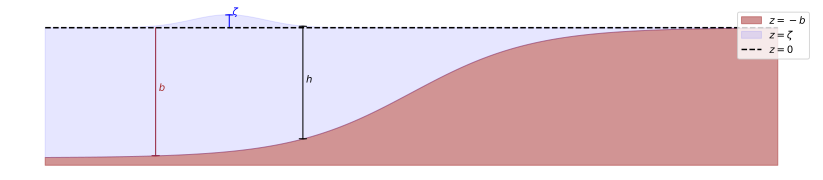

In [9]:
plot_initial_parametes()

#### Wyznaczenie początku i końca shoalingu oraz wizualizacja dla jednego przypadku:

Początek shoalingu został zdefiniowany jako moment, w którym amplituda fali zaczyna w zauważalny sposób rosnąć względem amplitudy na wodzie głębokiej. Przyjęto kryterium wzrostu amplitudy o 5% względem mediany amplitudy z obszaru głębokiej wody. Wyznaczenie końca shoalingu jest trudniejsze, ponieważ fizycznie fala powinna w pewnym momencie przegiąć się i zacząć się załamywać (breaking). W modelu równania płytkowodnego fala jednak się nie załamuje, tylko coraz bardziej się wysmukla, a maksimum przemieszcza się na czoło fali i zaczyna narastać niefizycznie. Aby wykryć moment, w którym kształt fali przestaje być fizycznie sensowny, zastosowano dwa niezależne kryteria: **liczba pików w lokalnym oknie**, **asymetria kształtu fali**. Poniżej pokazano: heatmapę $\zeta(x,y)$, przekrój $\zeta(x)$ oraz pole prędkości $u(x,y), v(x,y)$ dla przypadku $b_0 =3[m]$, aby przeanalizować zachowanie fali i zweryfikować algorytm wyznaczania początku i końca shoalingu.


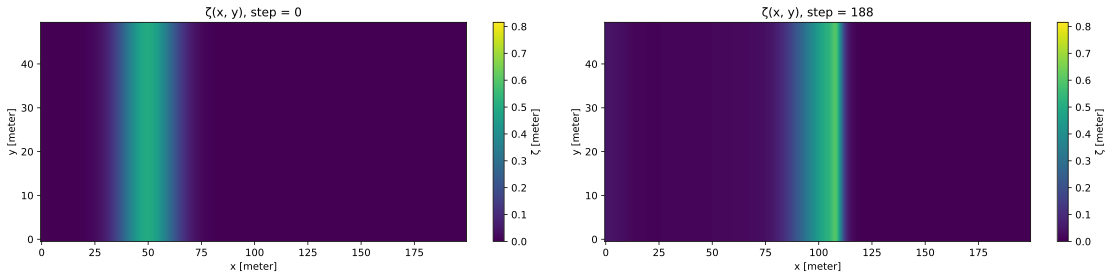

In [10]:
results = run_shoaling_test([2,3,4,5,6,7,8])
i = 2; pyplot.show(plot_zeta_heatmap(results["output"][i], results["bathy"][i], 0, results["end_i"][i]))

Heatmapa przedstawia globalny rozkład wysokości powierzchni swobodnej $\zeta(x,y)$ i pozwala porównać zarówno wysokość, jak i efektywną długość fali na początku symulacji oraz w momencie wykrycia końca shoalingu. Widać stopniowe skracanie długości fali, narastanie stromości frontu oraz wzrost amplitudy w miarę zbliżania się do płycizny. Dla analizowanego przypadku amplituda rośnie z około $0,5m$ do około $0,6m$, co jakościowo potwierdza, że shoaling prowadzi do zwiększenia wysokości fali i jej wyraźnej deformacji w rejonie przybrzeżnym.

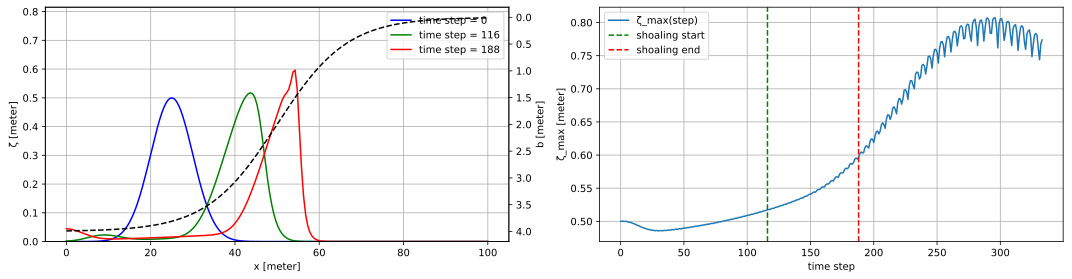

In [11]:
pyplot.show(plot_profile_with_amplitude(results["output"][i], results["bathy"][i], [0, results["start_i"][i], results["end_i"][i]], ["blue","green","red"], results["z_peak"][i], results["start_i"][i], results["end_i"][i]))


Wykresy dla przekrojów poprzecznych (wykres powyżej po lewej stronie) mogą nas utwierdzić w skuteczności wyznaczania początku oraz końca shoalingu. Jak można zauważyć, początek shoalingu wiąże się z minimalnym, ale wyraźnym wzrostem amplitudy fali, co zgadza się z przyjętym kryterium. Znacznie ciekawszy jest jednak moment zakończenia shoalingu. W tej fazie fala jest już mocno zdeformowana, a jej maksimum znajduje się prawie na samym przodzie fali, co mogłoby sugerować, że fizycznie doszłoby tutaj do przegięcia i rozpoczęcia zjawiska breaking. Takie zachowanie potwierdza, że wykryty moment końca shoalingu ma sens i odpowiada granicy, przy której fala przestaje zachowywać realistyczny kształt.

Dodatkowo warto zwrócić uwagę, że po tej chwili na wykresie przedstawiającym amplitudę dla kolejnych kroków symulacji (wykres powyżej po prawej stronie) pojawiają się gwałtowne, wysokoczęstotliwościowe oscylacje. Nie są one zjawiskiem fizycznym, lecz efektem numerycznym wynikającym z prób odwzorowania bardzo ostrego, niefizycznego piku, który w rzeczywistości uległby załamaniu. Dlatego uznanie właśnie tego kroku jako końca shoalingu jest zasadne.

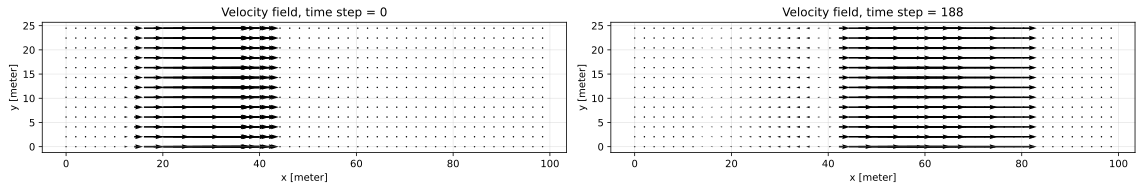

In [12]:
pyplot.show(plot_v_u(results["output"][i], results["bathy"][i], 0, results["end_i"][i]))

Na wykresie prędkości może wyglądać tak, jakby fala przyspieszała na płytszym obszarze, jednak zgodnie z teorią fala jako całość powinna zwalniać, ponieważ jej prędkość propagacji zależy od głębokości (czyli bathymetri), a
a więc im mniejsze (płytsza), tym mniejsza prędkość fali. Lokalny wzrost prędkości widoczny na wykresie nie oznacza więc przyspieszenia fali, lecz jedynie zwiększenie prędkości cząstek wody w jej froncie. Podczas shoalingu fala staje się coraz wyższa i bardziej stroma, przez co jej energia jest ściskana w mniejszej objętości wody. W efekcie przepływ wewnątrz fali zostaje silniej wypchnięty do przodu, co daje pozornie dłuższe wektory prędkości, mimo że sama fala propaguje się wolniej.

#### Zależność początku/końca shoalingu oraz amplitudy końcowej od maksymalnej głębokości:

Na wykresie widać, że wraz ze wzrostem początkowej głębokości $b_0$ głębokość, przy której rozpoczyna się shoaling, rośnie liniowo z nachyleniem mniejszym niż $1$. Oznacza to, że fale generowane na większej głębokości muszą dotrzeć proporcjonalnie płycej, aby pojawiło się wyraźne zwiększenie stromości.

Dla końca shoalingu zależność jest wyraźnie nieliniowa, ponieważ przy małych $b_0$ głębokość końcowa rośnie szybko, natomiast dla większych wartości krzywa wyraźnie się wypłaszcza. Oznacza to, że fale powstające na dużej głębokości wcześniej osiągają stan bliski załamaniu i kończą shoaling przy relatywnie wyższych głębokościach.

Amplituda końcowa również zwiększa się wraz z $b_0$, co jest naturalne, ponieważ energia fali musi się zachować, więc podczas zwalniania na płyciźnie wysokość fali wzrasta. Otrzymany przebieg dobrze zgadza się z wartością teoretyczną wynikającą z prawa Green’a opisującego shoaling fal długich $A(h) = A_0 \left( \frac{h_0}{h} \right)^{1/4}$, która została obliczona dla wyznaczonej głębokosci końca shoalingu. Potwierdza to poprawność zmierzonych amplitud w modelu numerycznym.

Dodatkowo analizowany stosunek $\frac{A(x_{\text{end}})}{b(x_{\text{end}})}$ oscyluje w pobliżu teoretycznego progu załamania fal płytkowodnych wynikającego z kryterium Miche’a
$\frac{H}{h} \le 0.88$ (gdzie H = 2A) co prowadzi do warunku $\frac{A}{h} \le 0.44$. Nieduże óżnice w wartościach od stałej $0.44$ pokazują, że fala w symulacji osiąga stan bliski fizycznego załamania w okolicy wyznaczonego końca shoalingu.



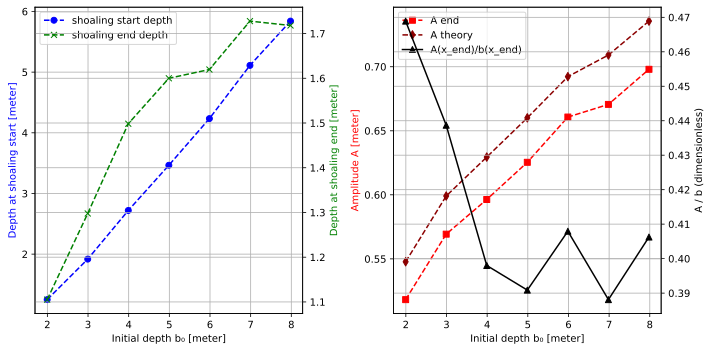

In [13]:
plot_shoaling_summary(results)

#### 2.4. Analiza zbieżności

Na wykresie przedstawiono porównanie profilu powierzchni swobodnej $\zeta(x)$ dla dwóch gęstości siatki (konfiguracje oznaczone jako $dx$ oraz $dx/2$) oraz dwóch kroków czasu ($dt$ oraz $dt/2$), w trzech wybranych momentach symulacji. Linie odpowiadające różnym parametrom numerycznym praktycznie na siebie nachodzą, co oznacza, że rozwiązanie jest zbieżne zarówno względem siatki przestrzennej, jak i kroku czasowego.

Różnice pomiędzy wariantami pojawiają się jedynie w okolicy najbardziej stromej części fali (tuż przed końcem shoalingu), gdzie gradient jest największy i metoda numeryczna jest najbardziej wrażliwa. Mimo tego przebieg fali pozostaje stabilny, a różnice są niewielkie i lokalne, co potwierdza, że konfiguracja bazowa (oznaczona jako $dx/1, dt/1$) zapewnia wystarczającą dokładność obliczeń i odtwarza oczekiwane zachowanie fizyczne fali.



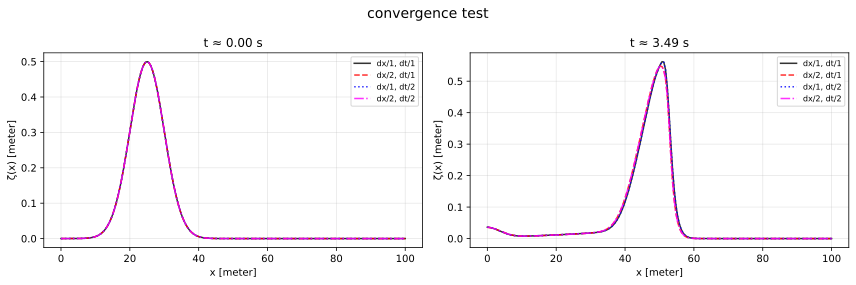

In [14]:
pyplot.show(convergence_check([0,169]))

#### Podsumowanie odpowiedzi na pytania badawcze

**1. Jak zmienia się fala przy zbliżaniu do płycizny?**

- Fala **skraca się** i staje się coraz bardziej **asymetryczna**: strome czoło, maksimum przesuwa się na przód fali (tam kończymy shoaling).
- Amplituda rośnie z ok. \(0{,}5\,\mathrm{m}\) do ok. \(0{,}55{-}0{,}75\,\mathrm{m}\), zgodnie z prawem Green’a  
  \(A(h) \approx A_0 (h_0/h)^{1/4}\) dla wyznaczonej głębokości końca shoalingu.
- Prędkość propagacji fali maleje jak \(c=\sqrt{g h}\), natomiast lokalna prędkość cząstek we froncie rośnie.

**2. Na jakiej głębokości zaczyna i kończy się shoaling? Jaka jest amplituda na końcu?**

- Początek shoalingu: głębokość startu rośnie **prawie liniowo** z \(b_0\), z nachyleniem mniejszym niż 1 (im większe \(b_0\), tym płycej fala musi dojść, by zaczął się wyraźny wzrost stromości).
- Koniec shoalingu: głębokość końcowa rośnie z \(b_0\) **nieliniowo** dla małych \(b_0\) zmienia się szybko, dla większych wartości krzywa się wypłaszcza.
- Stosunek \(A/h\) w punkcie końca shoalingu jest bliski wartości \(0{,}4\), czyli zbliżony do progu załamania fal płytkowodnych z kryterium Miche’a \((A/h \le 0{,}44)\).
